In [1]:
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
PICKLES_ADDRESS = '../data/pickles/'
LAG_DATA_ADDRESS = 'lag_data/'
TEMP_ADDRESS = 'temp/'

## Import Data

In [3]:
years = [str(year) for year in range(2010, 2022)]
START_YEAR, START_YEAR_IDX, SF_TAG = 2010, 0, 'SF10'
correlation_lags = list(range(-11 + START_YEAR_IDX, 11 - (START_YEAR_IDX - 1)))
print('years:', years)
print('correlation_lags:', correlation_lags)

years: ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
correlation_lags: [-11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [4]:
with open(PICKLES_ADDRESS + 'dui2children.pkl', 'rb') as handle:
    dui2children = pickle.load(handle)
    print('dui2children:', len(dui2children))
with open(PICKLES_ADDRESS + 'dui2trail_final.pkl', 'rb') as handle:
    dui2parents = pickle.load(handle)
    print('dui2parents:', len(dui2parents))
with open(PICKLES_ADDRESS + 'heading2dui_final.pkl', 'rb') as handle:
    dui2name = pickle.load(handle)
    print('dui2name:', len(dui2name))
with open(PICKLES_ADDRESS + 'dui2header_final.pkl', 'rb') as handle:
    name2dui = pickle.load(handle)
    print('name2dui:', len(name2dui))
with open(PICKLES_ADDRESS + 'dui2level_final.pkl', 'rb') as handle:
    dui2level = pickle.load(handle)
    print('dui2level:', len(dui2level))
with open(PICKLES_ADDRESS + 'level2duis_final.pkl', 'rb') as handle:
    level2duis = pickle.load(handle)
    print('level2duis:', len(level2duis))
with open(PICKLES_ADDRESS + 'dui2trail.pkl', 'rb') as handle:
    dui2trail = pickle.load(handle)
    print('dui2trail:', len(dui2trail))
with open(PICKLES_ADDRESS + 'dui_intersection_final.pkl', 'rb') as handle:
    dui_intersections = pickle.load(handle)
    print('dui_intersections:', len(dui_intersections))
with open(PICKLES_ADDRESS + 'excluded_duis_final.pkl', 'rb') as handle:
    excluded_duis = pickle.load(handle)
    print('excluded_duis:', len(excluded_duis))
with open(PICKLES_ADDRESS + 'dui2pubfreq.pkl', 'rb') as handle:
    dui2pubfreq = pickle.load(handle)
    print('dui2pubfreq:', len(dui2pubfreq))
with open(PICKLES_ADDRESS + 'dui2sbfreq.pkl', 'rb') as handle:
    dui2sbfreq = pickle.load(handle)
    print('dui2sbfreq:', len(dui2sbfreq))
with open(PICKLES_ADDRESS + 'dui2pubfreqchild.pkl', 'rb') as handle:
    dui2pubfreqchild = pickle.load(handle)
    print('dui2pubfreqchild:', len(dui2pubfreqchild))
with open(PICKLES_ADDRESS + 'dui2sbfreqchild.pkl', 'rb') as handle:
    dui2sbfreqchild = pickle.load(handle)
    print('dui2sbfreqchild:', len(dui2sbfreqchild))
with open(TEMP_ADDRESS + 'dui2pubcit.pkl', 'rb') as handle:
    dui2pubcit = pickle.load(handle)
    print('dui2pubcit:', len(dui2pubcit))
with open(TEMP_ADDRESS + 'dui2sbcit.pkl', 'rb') as handle:
    dui2sbcit = pickle.load(handle)
    print('dui2sbcit:', len(dui2sbcit))
with open(TEMP_ADDRESS + 'dui2pubcitchild.pkl', 'rb') as handle:
    dui2pubcitchild = pickle.load(handle)
    print('dui2pubcitchild:', len(dui2pubcitchild))
with open(TEMP_ADDRESS + 'dui2sbcitchild.pkl', 'rb') as handle:
    dui2sbcitchild = pickle.load(handle)
    print('dui2sbcitchild:', len(dui2sbcitchild))

dui2children: 29432
dui2parents: 29307
dui2name: 29307
name2dui: 29307
dui2level: 29307
level2duis: 14
dui2trail: 29432
dui_intersections: 29307
excluded_duis: 723
dui2pubfreq: 29307
dui2sbfreq: 29307
dui2pubfreqchild: 29307
dui2sbfreqchild: 29307
dui2pubcit: 29307
dui2sbcit: 29307
dui2pubcitchild: 29307
dui2sbcitchild: 29307


In [5]:
# store all duis that have no frequency at any year of the dui2pubfreq dictionary and store them in a list called exduis
exduis = {}
for dui in dui2sbfreq:
    c = 0
    for year in years:
        c += len(dui2sbfreq[dui][year])
    if c == 0:
        exduis[dui] = True
    else:
        exduis[dui] = False

len(exduis)

29307

In [6]:
# count how many excuis have False and True values
c = 0
for dui in exduis:
    if exduis[dui] == False:
        c += 1
print(c, 'DUIs remained.')

10873 DUIs remained.


100%|██████████| 12/12 [00:00<00:00, 15.79it/s]


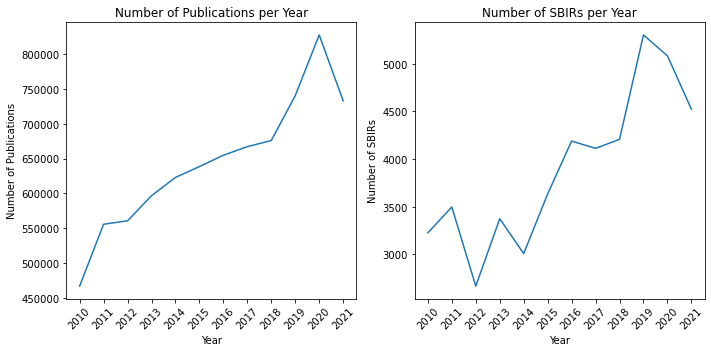

In [7]:
total_pubs_per_year = {}
for year in tqdm(years):
    pmids_list = []
    for dui in dui2pubcit:
        if not exduis[dui]:
            pmids_list += list(zip(dui2pubfreqchild[dui][year], dui2pubcitchild[dui][year]))
    pmids_set = set(pmids_list)
    # pmids_set = set([pmid for pmid in pmids_set if pmid[1] is not None])
    total_pubs_per_year[year] = np.sum([impact_score for _, impact_score in pmids_set])

total_sbirs_per_year = {}
for year in tqdm(years):
    sbids_list = []
    for dui in dui2sbfreq:
        if not exduis[dui]:
            sbids_list += list(zip(dui2sbfreqchild[dui][year], dui2sbcitchild[dui][year]))
    sbids_set = set(sbids_list)
    # sbids_set = set([sbid for sbid in sbids_set if sbid[1] is not None])
    total_sbirs_per_year[year] = np.sum([impact_score for _, impact_score in sbids_set])


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(total_pubs_per_year.keys(), total_pubs_per_year.values())
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of Publications')
axs[0].set_title('Number of Publications per Year')
axs[1].plot(total_sbirs_per_year.keys(), total_sbirs_per_year.values())
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Number of SBIRs')
axs[1].set_title('Number of SBIRs per Year')

for ax in axs:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

In [8]:
c = 0
dui2pubCitSigProp = {}
dui2sbCitSigProp = {}
for dui in tqdm(dui2pubcit):
    if not exduis[dui]:
        dui2pubCitSigProp[dui] = []
        dui2sbCitSigProp[dui] = []
        for year in years[START_YEAR_IDX:]:
            try:
                #remove those element from dui2pubcit[dui][year] that are None
                numerator = np.sum([impact_score for impact_score in dui2pubcit[dui][year] if impact_score is not None])
                dui2pubCitSigProp[dui].append(np.sum(numerator) / total_pubs_per_year[year])
            except KeyError:
                c += 1
            try:
                numerator = np.sum([impact_score for impact_score in dui2sbcit[dui][year] if impact_score is not None])
                dui2sbCitSigProp[dui].append(np.sum(numerator) / total_sbirs_per_year[year])
            except KeyError:
                c += 1

print('c:', c)
print('dui2pubCitSigProp:', len(dui2pubCitSigProp))
print('dui2sbCitSigProp:', len(dui2sbCitSigProp))
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2pubCitSigProp_sbCit.pkl', 'wb') as handle:
    pickle.dump(dui2pubCitSigProp, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2sbCitSigProp_sbCit.pkl', 'wb') as handle:
    pickle.dump(dui2sbCitSigProp, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 29307/29307 [00:07<00:00, 4172.27it/s]


c: 0
dui2pubCitSigProp: 10873
dui2sbCitSigProp: 10873


In [9]:
d = 0
dui2pubCitSigPropchild = {}
dui2sbCitSigPropchild = {}
for dui in tqdm(dui2pubcitchild):
    if not exduis[dui]:
        dui2pubCitSigPropchild[dui] = []
        dui2sbCitSigPropchild[dui] = []
        for year in years[START_YEAR_IDX:]:
            try:
                numerator = np.sum([impact_score for impact_score in dui2pubcitchild[dui][year] if impact_score is not None])
                dui2pubCitSigPropchild[dui].append(np.sum(numerator) / total_pubs_per_year[year])
            except KeyError:
                d += 1
            try:
                numerator = np.sum([impact_score for impact_score in dui2sbcitchild[dui][year] if impact_score is not None])
                dui2sbCitSigPropchild[dui].append(np.sum(numerator) / total_sbirs_per_year[year])
            except KeyError:
                d += 1

print('d:', d)
print('dui2pubCitSigPropchild:', len(dui2pubCitSigPropchild))
print('dui2sbCitSigPropchild:', len(dui2sbCitSigPropchild))

with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2pubCitSigPropchild_sbCit.pkl', 'wb') as handle:
    pickle.dump(dui2pubCitSigPropchild, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2sbCitSigPropchild_sbCit.pkl', 'wb') as handle:
    pickle.dump(dui2sbCitSigPropchild, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 29307/29307 [00:18<00:00, 1561.15it/s]


d: 0
dui2pubCitSigPropchild: 10873
dui2sbCitSigPropchild: 10873


In [10]:
# read the pickles
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2pubCitSigProp_sbCit.pkl', 'rb') as handle:
    dui2pubCitSigProp = pickle.load(handle)
    print('dui2pubCitSigProp:', len(dui2pubCitSigProp))
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2sbCitSigProp_sbCit.pkl', 'rb') as handle:
    dui2sbCitSigProp = pickle.load(handle)
    print('dui2sbCitSigProp:', len(dui2sbCitSigProp))
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2pubCitSigPropchild_sbCit.pkl', 'rb') as handle:
    dui2pubCitSigPropchild = pickle.load(handle)
    print('dui2pubCitSigPropchild:', len(dui2pubCitSigPropchild))
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2sbCitSigPropchild_sbCit.pkl', 'rb') as handle:
    dui2sbCitSigPropchild = pickle.load(handle)
    print('dui2sbCitSigPropchild:', len(dui2sbCitSigPropchild))

dui2pubCitSigProp: 10873
dui2sbCitSigProp: 10873
dui2pubCitSigPropchild: 10873
dui2sbCitSigPropchild: 10873


In [11]:
sample_dui = 'D000077321'
sample_name = dui2name[sample_dui]

print(sample_dui, sample_name)
print('dui2pubCitSigProp[sample_dui]', dui2pubCitSigProp[sample_dui])
print('dui2sbCitSigProp[sample_dui]', dui2sbCitSigProp[sample_dui])
print('dui2pubCitSigPropchild[sample_dui]', dui2pubCitSigPropchild[sample_dui])
print('dui2sbCitSigPropchild[sample_dui]', dui2sbCitSigPropchild[sample_dui])

D000077321 Deep Learning
dui2pubCitSigProp[sample_dui] [1.7132225984768382e-05, 1.8441130738171477e-05, 2.4077207578969896e-05, 2.5136543800637043e-05, 2.568452262706113e-05, 3.171225008985137e-05, 4.276100150847069e-05, 0.00015514392034446446, 0.0010418816449080947, 0.0021137572846120158, 0.002511722428838308, 0.003491068166568366]
dui2sbCitSigProp[sample_dui] [0.0, 0.00021442355800157243, 0.0007498359733808229, 0.0005927243091057272, 0.0004985044865403788, 0.0011694297310311619, 0.002267438391312131, 0.0046194991490396305, 0.00861556743909685, 0.013812936073920423, 0.015343004671748218, 0.011438359949162844]
dui2pubCitSigPropchild[sample_dui] [1.7132225984768382e-05, 1.8441130738171477e-05, 2.4077207578969896e-05, 2.5136543800637043e-05, 2.568452262706113e-05, 3.171225008985137e-05, 4.276100150847069e-05, 0.00015514392034446446, 0.0010418816449080947, 0.0021137572846120158, 0.002511722428838308, 0.003491068166568366]
dui2sbCitSigPropchild[sample_dui] [0.0, 0.00021442355800157243, 0.0

In [12]:
sample_dui = 'D000077321'
sample_name = dui2name[sample_dui]

print(sample_dui, sample_name)
print('dui2pubCitSigProp[sample_dui]', dui2pubCitSigProp[sample_dui])
print('dui2sbCitSigProp[sample_dui]', dui2sbCitSigProp[sample_dui])
print('dui2pubCitSigPropchild[sample_dui]', dui2pubCitSigPropchild[sample_dui])
print('dui2sbCitSigPropchild[sample_dui]', dui2sbCitSigPropchild[sample_dui])

D000077321 Deep Learning
dui2pubCitSigProp[sample_dui] [1.7132225984768382e-05, 1.8441130738171477e-05, 2.4077207578969896e-05, 2.5136543800637043e-05, 2.568452262706113e-05, 3.171225008985137e-05, 4.276100150847069e-05, 0.00015514392034446446, 0.0010418816449080947, 0.0021137572846120158, 0.002511722428838308, 0.003491068166568366]
dui2sbCitSigProp[sample_dui] [0.0, 0.00021442355800157243, 0.0007498359733808229, 0.0005927243091057272, 0.0004985044865403788, 0.0011694297310311619, 0.002267438391312131, 0.0046194991490396305, 0.00861556743909685, 0.013812936073920423, 0.015343004671748218, 0.011438359949162844]
dui2pubCitSigPropchild[sample_dui] [1.7132225984768382e-05, 1.8441130738171477e-05, 2.4077207578969896e-05, 2.5136543800637043e-05, 2.568452262706113e-05, 3.171225008985137e-05, 4.276100150847069e-05, 0.00015514392034446446, 0.0010418816449080947, 0.0021137572846120158, 0.002511722428838308, 0.003491068166568366]
dui2sbCitSigPropchild[sample_dui] [0.0, 0.00021442355800157243, 0.0

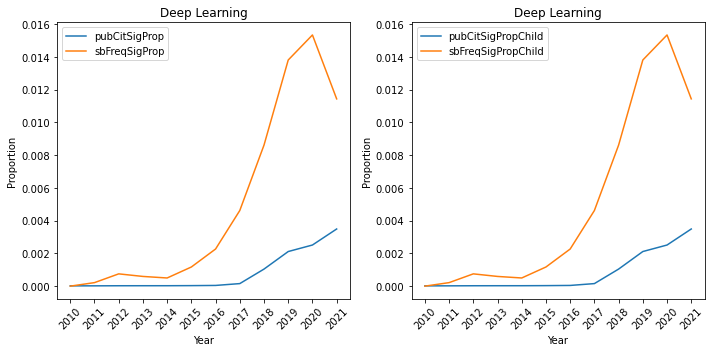

In [13]:
# now plot dui2pubCitSigPropChild[sample_dui] and dui2pubFreqSigPropChild[sample_dui] next to each other. specify sbirs with red and publications with blue lines. make the font size of x axis and y axis and the title bigger.
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(years[START_YEAR_IDX:], dui2pubCitSigProp[sample_dui], label='pubCitSigProp')
ax[0].plot(years[START_YEAR_IDX:], dui2sbCitSigProp[sample_dui], label='sbFreqSigProp')
ax[0].set_title(sample_name)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Proportion')
ax[0].legend()
ax[1].plot(years[START_YEAR_IDX:], dui2pubCitSigPropchild[sample_dui], label='pubCitSigPropChild')
ax[1].plot(years[START_YEAR_IDX:], dui2sbCitSigPropchild[sample_dui], label='sbFreqSigPropChild')
ax[1].set_title(sample_name)
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Proportion')
ax[1].legend()
for a in ax.flat:
    for tick in a.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

In [14]:
# use minmax scaling to scale the values in dui2pubCitSigProp and dui2sbCitSigProp to be between 0 and 1. also account for ZeroDivisionError.
dui2pubCitSigPropScaled = {}
dui2sbCitSigPropScaled = {}
z1, z2, z3, z4 = 0, 0, 0, 0
c = 0

for dui in tqdm(dui2pubCitSigProp):
    dui2pubCitSigPropScaled[dui] = []
    dui2sbCitSigPropScaled[dui] = []
    if len(dui2pubCitSigProp[dui]) == 0:
        c += 1
        continue
    
    min_val_pub = min(dui2pubCitSigProp[dui])
    max_val_pub = max(dui2pubCitSigProp[dui])
    min_val_sb = min(dui2sbCitSigProp[dui])
    max_val_sb = max(dui2sbCitSigProp[dui])
    
    if (min_val_pub == max_val_pub):
        dui2pubCitSigPropScaled[dui] = [0] * len(years)
    else:
        for i in range(START_YEAR_IDX, len(years)):
            dui2pubCitSigPropScaled[dui].append((dui2pubCitSigProp[dui][i-START_YEAR_IDX] - min_val_pub) / (max_val_pub - min_val_pub))
    if (min_val_sb == max_val_sb):
        dui2sbCitSigPropScaled[dui] = [0] * len(years)
    else:
        for i in range(START_YEAR_IDX, len(years)):
            dui2sbCitSigPropScaled[dui].append((dui2sbCitSigProp[dui][i-START_YEAR_IDX] - min_val_sb) / (max_val_sb - min_val_sb))

    if np.sum(dui2pubCitSigPropScaled[dui]) == 0:
        # del dui2pubCitSigPropScaled[dui]
        z1 += 1
    elif np.sum(dui2sbCitSigPropScaled[dui]) == 0:
        # del dui2sbCitSigPropScaled[dui]
        z2 += 1

dui2pubCitSigPropScaledchild = {}
dui2sbCitSigPropScaledchild = {}
d = 0

for dui in tqdm(dui2pubCitSigPropchild):
    dui2pubCitSigPropScaledchild[dui] = []
    dui2sbCitSigPropScaledchild[dui] = []
    if len(dui2pubCitSigProp[dui]) == 0:
        d += 1
        continue
    
    min_val_pub = min(dui2pubCitSigPropchild[dui])
    max_val_pub = max(dui2pubCitSigPropchild[dui])
    min_val_sb = min(dui2sbCitSigPropchild[dui])
    max_val_sb = max(dui2sbCitSigPropchild[dui])
    
    if (min_val_pub == max_val_pub):
        dui2pubCitSigPropScaledchild[dui] = [0] * len(years)
    else:
        for i in range(START_YEAR_IDX, len(years)):
            dui2pubCitSigPropScaledchild[dui].append((dui2pubCitSigPropchild[dui][i-START_YEAR_IDX] - min_val_pub) / (max_val_pub - min_val_pub))
    if (min_val_sb == max_val_sb):
        dui2sbCitSigPropScaledchild[dui] = [0] * len(years)
    else:
        for i in range(START_YEAR_IDX, len(years)):
            dui2sbCitSigPropScaledchild[dui].append((dui2sbCitSigPropchild[dui][i-START_YEAR_IDX] - min_val_sb) / (max_val_sb - min_val_sb))

    if np.sum(dui2pubCitSigPropScaledchild[dui]) == 0:
        # del dui2pubCitSigPropScaledchild[dui]
        z3 += 1
    elif np.sum(dui2sbCitSigPropScaledchild[dui]) == 0:
        # del dui2sbCitSigPropScaledchild[dui]
        z4 += 1

print('c', c)
print('d', d)
print('z1', z1)
print('z2', z2)
print('z3', z3)
print('z4', z4)
print('len(dui2pubCitSigPropScaled)', len(dui2pubCitSigPropScaled))
print('len(dui2sbCitSigPropScaled)', len(dui2sbCitSigPropScaledchild))
print('len(dui2pubCitSigPropScaledchild)', len(dui2pubCitSigPropScaledchild))
print('len(dui2sbCitSigPropScaledchild)', len(dui2sbCitSigPropScaledchild))

100%|██████████| 10873/10873 [00:00<00:00, 60300.18it/s]

c 0
d 0
z1 834
z2 0
z3 834
z4 0
len(dui2pubCitSigPropScaled) 10873
len(dui2sbCitSigPropScaled) 10873
len(dui2pubCitSigPropScaledchild) 10873
len(dui2sbCitSigPropScaledchild) 10873


In [15]:
# dui2sbCitSigPropchild['D009490']

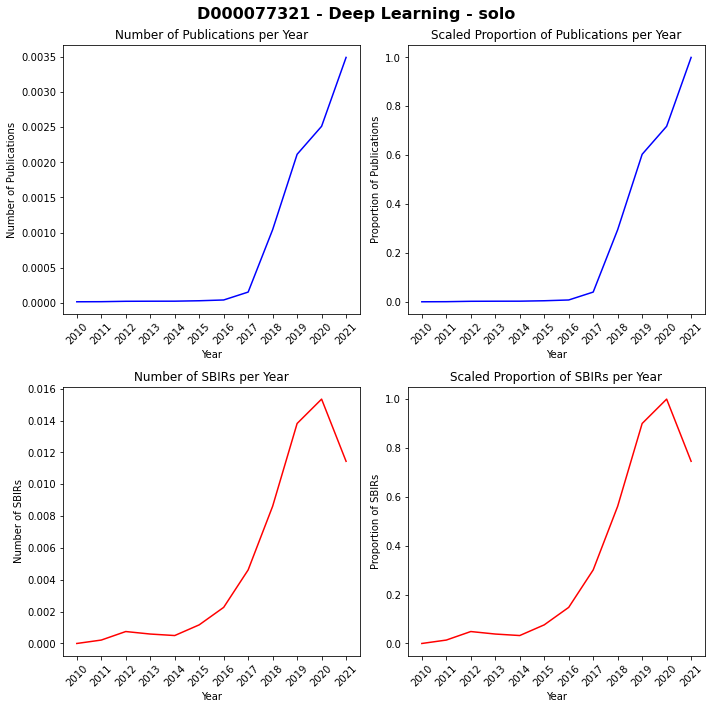

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(str(sample_dui) + ' - ' + sample_name + ' - solo', fontsize=16, fontweight='bold')
axs[0, 0].plot(years[START_YEAR_IDX:], dui2pubCitSigProp[sample_dui], color='blue')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Number of Publications')
axs[0, 0].set_title('Number of Publications per Year')
axs[0, 1].plot(years[START_YEAR_IDX:], dui2pubCitSigPropScaled[sample_dui], color='blue')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Proportion of Publications')
axs[0, 1].set_title('Scaled Proportion of Publications per Year')
axs[1, 0].plot(years[START_YEAR_IDX:], dui2sbCitSigProp[sample_dui], color='red')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Number of SBIRs')
axs[1, 0].set_title('Number of SBIRs per Year')
axs[1, 1].plot(years[START_YEAR_IDX:], dui2sbCitSigPropScaled[sample_dui], color='red')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Proportion of SBIRs')
axs[1, 1].set_title('Scaled Proportion of SBIRs per Year')

for ax in axs.flat:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()


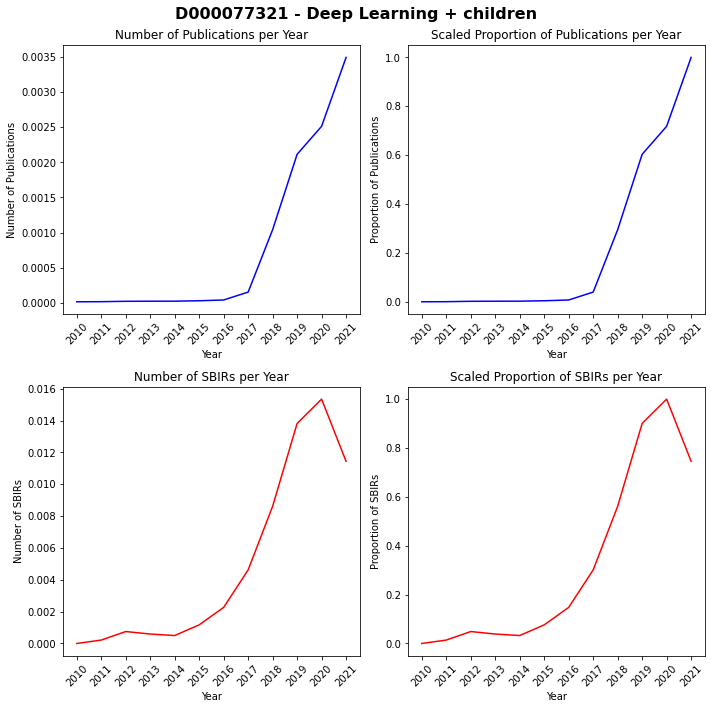

In [17]:
#draw the same for dui2pubFreqSigchild and dui2pubCitSigPropchild 

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(str(sample_dui) + ' - ' + sample_name + ' + children', fontsize=16, fontweight='bold')
axs[0, 0].plot(years[START_YEAR_IDX:], dui2pubCitSigPropchild[sample_dui], color='blue')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Number of Publications')
axs[0, 0].set_title('Number of Publications per Year')
axs[0, 1].plot(years[START_YEAR_IDX:], dui2pubCitSigPropScaledchild[sample_dui], color='blue')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Proportion of Publications')
axs[0, 1].set_title('Scaled Proportion of Publications per Year')
axs[1, 0].plot(years[START_YEAR_IDX:], dui2sbCitSigPropchild[sample_dui], color='red')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Number of SBIRs')
axs[1, 0].set_title('Number of SBIRs per Year')
axs[1, 1].plot(years[START_YEAR_IDX:], dui2sbCitSigPropScaledchild[sample_dui], color='red')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Proportion of SBIRs')
axs[1, 1].set_title('Scaled Proportion of SBIRs per Year')

for ax in axs.flat:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

In [18]:
#save dui2pubCitSigPropScaled and dui2sbCitSigPropScaled, dui2pubCitSigPropScaledchild and dui2sbCitSigPropScaledchild to data/pickles

with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2pubCitSigPropScaled.pickle', 'wb') as f:
    pickle.dump(dui2pubCitSigPropScaled, f)

with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2sbCitSigPropScaled_cVersion.pickle', 'wb') as f:
    pickle.dump(dui2sbCitSigPropScaled, f)

with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2pubCitSigPropScaledchild.pickle', 'wb') as f:
    pickle.dump(dui2pubCitSigPropScaledchild, f)

with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2sbCitSigPropScaledchild_cVersion.pickle', 'wb') as f:
    pickle.dump(dui2sbCitSigPropScaledchild, f)

print('dui2pubCitSigPropScaled', len(dui2pubCitSigPropScaled))
print('dui2sbCitSigPropScaled', len(dui2sbCitSigPropScaled))
print('dui2pubCitSigPropScaledchild', len(dui2pubCitSigPropScaledchild))
print('dui2sbCitSigPropScaledchild', len(dui2sbCitSigPropScaledchild))                                

dui2pubCitSigPropScaled 10873
dui2sbCitSigPropScaled 10873
dui2pubCitSigPropScaledchild 10873
dui2sbCitSigPropScaledchild 10873


In [19]:
#load dui2pubCitSigPropScaled and dui2sbCitSigPropScaled, dui2pubCitSigPropScaledchild and dui2sbCitSigPropScaledchild from data/pickles

with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2pubCitSigPropScaled.pickle', 'rb') as f:
    dui2pubCitSigPropScaled = pickle.load(f)

with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2sbCitSigPropScaled_cVersion.pickle', 'rb') as f:
    dui2sbCitSigPropScaled = pickle.load(f)

with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2pubCitSigPropScaledchild.pickle', 'rb') as f:
    dui2pubCitSigPropScaledchild = pickle.load(f)

with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2sbCitSigPropScaledchild_cVersion.pickle', 'rb') as f:
    dui2sbCitSigPropScaledchild = pickle.load(f)

print('dui2pubCitSigPropScaled', len(dui2pubCitSigPropScaled))
print('dui2sbCitSigPropScaled', len(dui2sbCitSigPropScaled))
print('dui2pubCitSigPropScaledchild', len(dui2pubCitSigPropScaledchild))
print('dui2sbCitSigPropScaledchild', len(dui2sbCitSigPropScaledchild))

dui2pubCitSigPropScaled 10873
dui2sbCitSigPropScaled 10873
dui2pubCitSigPropScaledchild 10873
dui2sbCitSigPropScaledchild 10873


In [20]:
# ('D000081186', 'Blockchain')
# ('D000077321', 'Deep Learning')
# ('D012137', 'Respiratory System')
# ('D000069550', 'Machine Learning')
# ('D019876', 'Sports Equipment')

sample_dui = 'D000069550'
year = '2020'
sample_name = dui2name[sample_dui]
print(sample_dui, sample_name, year)

D000069550 Machine Learning 2020


In [21]:
print(len(dui2pubfreq[sample_dui][year]), dui2pubfreq[sample_dui][year])
print(len(dui2sbfreq[sample_dui][year]), dui2sbfreq[sample_dui][year])
print(len(dui2pubfreqchild[sample_dui][year]), dui2pubfreqchild[sample_dui][year])
print(len(dui2sbfreqchild[sample_dui][year]), dui2sbfreqchild[sample_dui][year])

5136 [32538625, 33161227, 32079904, 32473122, 32833571, 32079910, 33194024, 31424555, 33521709, 32079917, 32768046, 32768053, 31916093, 32014404, 32047172, 32178250, 33095769, 32243801, 32047210, 32505964, 32702573, 32702574, 32899184, 31916153, 31948926, 32145537, 33554565, 32768133, 32931989, 33489060, 32276658, 32014516, 32309431, 32112826, 33226940, 32932028, 33194173, 32309439, 32997569, 32211144, 32964809, 33226957, 33030350, 32473309, 32407774, 32080093, 32800992, 32375024, 32899326, 32112901, 32112907, 32899346, 32932128, 32801058, 32375076, 32047411, 33358138, 33456445, 32375102, 32997716, 32735577, 33096026, 33227106, 32407907, 35520871, 33358189, 32735604, 32473467, 33292688, 32932240, 32113043, 32637333, 32833958, 33259944, 32080299, 32604588, 33227180, 32735660, 33128875, 32604598, 32702902, 32866745, 32768443, 32604604, 33259973, 32833991, 32080330, 32866762, 32604623, 32604633, 32604635, 32866798, 33489395, 33128961, 32539144, 32604683, 32801298, 32342553, 32244257, 3260

In [22]:
print(np.sum(dui2pubcit[sample_dui][year]), dui2pubcit[sample_dui][year])
print(np.sum(dui2sbcit[sample_dui][year]), dui2sbcit[sample_dui][year])
print(np.sum(dui2pubcitchild[sample_dui][year]), dui2pubcitchild[sample_dui][year])
print(np.sum(dui2sbcitchild[sample_dui][year]), dui2sbcitchild[sample_dui][year])

3601.5 [1, 1, 1, 0.75, 1, 0.5, 0.25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.25, 1, 0.5, 0.25, 0.75, 0.25, 0.75, 1, 1, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 1, 0.25, 1, 0.25, 1, 0.25, 0.75, 0.5, 1, 0.75, 1, 0.25, 0.5, 0.5, 0.75, 1, 0.75, 0.75, 1, 1, 1, 0.75, 0.5, 0.5, 0.25, 1, 0.25, 1, 1, 1, 1, 1, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 1, 0.25, 0.75, 1, 1, 1, 0.25, 1, 1, 0.5, 0.5, 0.75, 1, 0.75, 1, 0.5, 1, 1, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 1, 1, 1, 0.25, 0.25, 0.5, 1, 0.25, 0.75, 1, 0.75, 0.5, 0.5, 0.25, 0.75, 0.75, 0.25, 1, 0.25, 0.5, 1, 0.5, 1, 0.75, 1, 1, 0.75, 1, 0.5, 0.5, 1, 0.25, 1, 0.5, 0.5, 1, 0.5, 0.5, 0.5, 0.5, 1, 1, 0.5, 0.5, 0.75, 1, 0.75, 0.75, 1, 0.25, 1, 1, 0.75, 0.5, 1, 0.75, 0.5, 0.5, 1, 1, 0.5, 0.25, 0.25, 0.75, 1, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.75, 1, 0.75, 0.25, 0.75, 0.75, 1, 0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 1, 0.75, 1, 1, 1, 0.75, 1, 0.5, 0.25, 0.75, 0.5, 1, 1, 0.25, 0.25, 0.75, 0.5, 1, 1, 0.25, 0.25, 1, 1, 0.5, 0.75, 0.25, 0.5, 1, 1, 1, 1, 0.75, 0.75, 1, 

In [23]:
print(dui2pubCitSigProp[sample_dui])
print(dui2sbCitSigProp[sample_dui])
print(dui2pubCitSigPropchild[sample_dui])
print(dui2sbCitSigPropchild[sample_dui])

[0.00011939019983135465, 0.00010255067825129504, 0.00012618240268237927, 0.00017260426743104105, 0.00029777993420749, 0.0010938768734696882, 0.0014416566222855832, 0.0019670300432079566, 0.0028926362601441992, 0.0038067890777501385, 0.0043526853494339785, 0.005928402742504556]
[0.002247016891368356, 0.0036452004860267314, 0.003374261880213703, 0.005260428243313329, 0.006314390162844799, 0.0074981082754350965, 0.008890745271197565, 0.01349380014587892, 0.023648247177658944, 0.04148595134829342, 0.04991394148020654, 0.047908493120406695]
[0.00020933438625138866, 0.0005271464689057798, 0.0007896432337473275, 0.0009044966344262563, 0.001098815983638959, 0.0019203529221076667, 0.0022995492150492763, 0.0030863896810555784, 0.004899469701845059, 0.0067262052890529325, 0.007522175097841755, 0.010116047144770851]
[0.002634433596776693, 0.004002573082696019, 0.0045927453369575405, 0.0057049714751426246, 0.006646726487205052, 0.008186008117218133, 0.011217853093860015, 0.01823486506199854, 0.0311

In [24]:
print(dui2pubCitSigPropScaled[sample_dui])
print(dui2sbCitSigPropScaled[sample_dui])
print(dui2pubCitSigPropScaledchild[sample_dui])
print(dui2sbCitSigPropScaledchild[sample_dui]) 

[0.002890482180861564, 0.0, 0.004056355048231605, 0.012024608316024114, 0.03351085022465616, 0.1701598640482228, 0.2298558098052101, 0.32003548054316144, 0.47891459500191214, 0.6358277482237512, 0.7295301398504447, 1.0]
[0.0, 0.02933236424876838, 0.023648368309234405, 0.06321807790072116, 0.08532904748020749, 0.11016216022663965, 0.13937816289043584, 0.2359452251539665, 0.4489744297726722, 0.8231899749226398, 1.0, 0.9579278844377251]
[0.0, 0.0320804781970773, 0.058577336563724575, 0.07017082912564007, 0.08978574619746031, 0.1727130459480473, 0.21098974803729606, 0.29041472836991383, 0.47343002970993586, 0.6578237465497563, 0.7381702578689943, 1.0]
[0.0, 0.023528788046563283, 0.0336783656476739, 0.052806044758272684, 0.06900202060624414, 0.09547405184961537, 0.14761466951296, 0.2682908059871504, 0.4911625997872793, 0.8367911530271522, 1.0, 0.9335071277208684]


## Frequency Analysis

### Cross-Correlation

In [25]:
# create a dui2cc dictionary that maps a dui to a scipy cross correlation between the scaled pub and sbir frequencies
a, b, c, d, cnan = 0, 0, 0, 0, 0
dui2cc = {}
dui2ccchild = {}
for dui in tqdm(dui2pubCitSigPropScaled):
    sigA, sigB = dui2pubCitSigPropScaled[dui], dui2sbCitSigPropScaled[dui]
    if len(sigA) == 0:
        a += 1
        continue
    if len(sigB) == 0:
        b += 1
        continue
    # if there is a nan, add one to cnan
    if np.isnan(sigA).any() or np.isnan(sigB).any():
        cnan += 1
    sigA = np.nan_to_num(sigA)
    sigB = np.nan_to_num(sigB)
    corr = signal.correlate(sigB, sigA, mode='full') / len(years)
    corr = corr.astype(np.float64)
    lags = signal.correlation_lags(len(sigB), len(sigA))
    corr /= np.max(corr) + 1e-8
    dui2cc[dui] = corr
    
for dui in tqdm(dui2pubCitSigPropScaledchild):
    sigA, sigB = dui2pubCitSigPropScaledchild[dui], dui2sbCitSigPropScaledchild[dui]
    if len(sigA) == 0:
        c += 1
        continue
    if len(sigB) == 0:
        d += 1
        continue
    sigA = np.nan_to_num(sigA)
    sigB = np.nan_to_num(sigB)
    corr = signal.correlate(sigB, sigA, mode='full') / len(years)
    corr = corr.astype(np.float64)
    lags = signal.correlation_lags(len(sigB), len(sigA))
    corr /= np.max(corr) + 1e-8
    dui2ccchild[dui] = corr

#save the dui2cc and dui2ccchild dictionaries in data/pickle
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2cc_cVersion.pickle', 'wb') as handle:
    pickle.dump(dui2cc, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2ccchild_cVersion.pickle', 'wb') as handle:
    pickle.dump(dui2ccchild, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(a, b)
print(c, d)
print(cnan)
print('Saved dui2cc and dui2ccchild.')
print('len(dui2cc):', len(dui2cc))
print('len(dui2ccchild):', len(dui2ccchild))

100%|██████████| 10873/10873 [00:00<00:00, 27357.79it/s]


0 0
0 0
0
Saved dui2cc and dui2ccchild.
len(dui2cc): 10873
len(dui2ccchild): 10873


In [26]:
len(lags), len(dui2cc[sample_dui])
lags

array([-11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
         2,   3,   4,   5,   6,   7,   8,   9,  10,  11])

In [27]:
#load the dui2cc and dui2ccchild dictionaries from data/pickle
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2cc_cVersion.pickle', 'rb') as handle:
    dui2cc = pickle.load(handle)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2ccchild_cVersion.pickle', 'rb') as handle:
    dui2ccchild = pickle.load(handle)

print('Loaded dui2cc and dui2ccchild.')

Loaded dui2cc and dui2ccchild.


In [28]:
# ('D000081186', 'Blockchain')
# ('D000077321', 'Deep Learning')
# ('D012137', 'Respiratory System')
# ('D000069550', 'Machine Learning')
# ('D009490', ''Neurosecretory Systems')
# ('D019876', 'Sports Equipment')
# ('D014612', 'Vaccines')
# ('D009369', 'Neoplasms')
# ('D009446', 'Neurobiology')

sample_dui = 'D009446'
sample_name = dui2name[sample_dui]
print(sample_dui, sample_name)
print(dui2pubCitSigPropScaled[sample_dui])
print(dui2sbCitSigPropScaled[sample_dui])
print(dui2pubCitSigPropScaledchild[sample_dui])
print(dui2sbCitSigPropScaledchild[sample_dui]) 

D009446 Neurobiology
[0.7099054786984839, 1.0, 0.39785021956619804, 0.34034933529577344, 0.2608340719991169, 0.2744581184519772, 0.35272373022316666, 0.0, 0.11181258115504435, 0.08850422367080678, 0.11804228174381384, 0.1631778694719182]
[0.12434526576785991, 0.0, 0.0, 0.17835074460991332, 1.0, 0.8831533328747334, 0.33515126200847306, 0.2438609287624605, 0.4290909090909091, 0.3404488025645861, 0.31567248586181457, 0.354710725534619]
[0.7099054786984839, 1.0, 0.39785021956619804, 0.34034933529577344, 0.2608340719991169, 0.2744581184519772, 0.35272373022316666, 0.0, 0.11181258115504435, 0.08850422367080678, 0.11804228174381384, 0.1631778694719182]
[0.12434526576785991, 0.0, 0.0, 0.17835074460991332, 1.0, 0.8831533328747334, 0.33515126200847306, 0.2438609287624605, 0.4290909090909091, 0.3404488025645861, 0.31567248586181457, 0.354710725534619]


In [29]:
c = 0
for dui in dui2sbCitSigPropScaled:
    if sum(dui2sbCitSigPropScaled[dui]) == 0:
        c += 1
len(dui2sbCitSigPropScaled), c

(10873, 833)

maximum_correlation_lag: 4
pos_auc: 5.38928899852477
neg_auc: 1.220014058418115


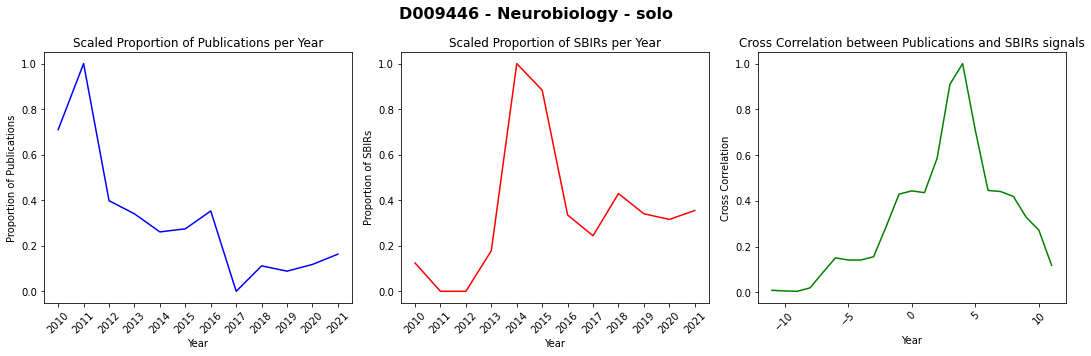

In [30]:
# plot three plots next to each other, one for dui2pubCitSigPropScaled, one for dui2sbCitSigPropScaled, and one for dui2cc
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(str(sample_dui) + ' - ' + sample_name + ' - solo', fontsize=16, fontweight='bold')
axs[0].plot(years[START_YEAR_IDX:], dui2pubCitSigPropScaled[sample_dui], color='blue')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Proportion of Publications')
axs[0].set_title('Scaled Proportion of Publications per Year')
axs[1].plot(years[START_YEAR_IDX:], dui2sbCitSigPropScaled[sample_dui], color='red')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Proportion of SBIRs')
axs[1].set_title('Scaled Proportion of SBIRs per Year')
axs[2].plot(correlation_lags, dui2cc[sample_dui], color='green')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Cross Correlation')
axs[2].set_title('Cross Correlation between Publications and SBIRs signals')

# calculate the maximum correlation lag
maximum_correlation_lag = correlation_lags[np.argmax(dui2cc[sample_dui])]
print('maximum_correlation_lag:', maximum_correlation_lag)
#calcualte the AUC of the cross-correlation signal
zero_index = correlation_lags.index(0)
pos_auc = np.trapz(dui2cc[sample_dui][zero_index + 1:], dx=1)
neg_auc = np.trapz(dui2cc[sample_dui][:zero_index], dx=1)
print('pos_auc:', pos_auc)
print('neg_auc:', neg_auc)

for ax in axs.flat:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

In [31]:
# create dui2mcclag and dui2mcclagchild
dui2mcclag = {}
dui2mcclagchild = {}
dui2aucratio = {}
dui2aucratiochild = {}
for dui in tqdm(dui2cc):
    dui2mcclag[dui] = correlation_lags[np.argmax(dui2cc[dui])]
for dui in tqdm(dui2ccchild):
    dui2mcclagchild[dui] = correlation_lags[np.argmax(dui2ccchild[dui])]
for dui in tqdm(dui2cc):
    zero_index = correlation_lags.index(0)
    pos_auc = np.trapz(dui2cc[dui][zero_index + 1:], dx=1)
    neg_auc = np.trapz(dui2cc[dui][:zero_index], dx=1)
    dui2aucratio[dui] = (pos_auc + 1) / (neg_auc + 1)
for dui in tqdm(dui2ccchild):
    zero_index = correlation_lags.index(0)
    pos_auc = np.trapz(dui2ccchild[dui][zero_index:], dx=1)
    neg_auc = np.trapz(dui2ccchild[dui][:zero_index], dx=1)
    dui2aucratiochild[dui] = (pos_auc + 1) / (neg_auc + 1)

with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2mcclag_cVersion.pickle', 'wb') as handle:
    pickle.dump(dui2mcclag, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2mcclagchild_cVersion.pickle', 'wb') as handle:
    pickle.dump(dui2mcclagchild, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2aucratio_cVersion.pickle', 'wb') as handle:
    pickle.dump(dui2aucratio, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2aucratiochild_cVersion.pickle', 'wb') as handle:
    pickle.dump(dui2aucratiochild, handle, protocol=pickle.HIGHEST_PROTOCOL)

print('len(dui2mcclag):', len(dui2mcclag))
print('len(dui2mcclagchild):', len(dui2mcclagchild))
print('len(dui2aucratio):', len(dui2aucratio))
print('len(dui2aucratiochild):', len(dui2aucratiochild))

100%|██████████| 10873/10873 [00:00<00:00, 92156.15it/s]

len(dui2mcclag): 10873
len(dui2mcclagchild): 10873
len(dui2aucratio): 10873
len(dui2aucratiochild): 10873


In [32]:
# load dui2mcclag and dui2mcclagchild from data/pickle
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2mcclag_cVersion.pickle', 'rb') as handle:
    dui2mcclag = pickle.load(handle)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2mcclagchild_cVersion.pickle', 'rb') as handle:
    dui2mcclagchild = pickle.load(handle)
# load dui2aucratio and dui2aucratiochild from data/pickle
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2aucratio_cVersion.pickle', 'rb') as handle:
    dui2aucratio = pickle.load(handle)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2aucratiochild_cVersion.pickle', 'rb') as handle:
    dui2aucratiochild = pickle.load(handle)

print('len(dui2mcclag):', len(dui2mcclag))
print('len(dui2mcclagchild):', len(dui2mcclagchild))
print('len(dui2aucratio):', len(dui2aucratio))
print('len(dui2aucratiochild):', len(dui2aucratiochild))

len(dui2mcclag): 10873
len(dui2mcclagchild): 10873
len(dui2aucratio): 10873
len(dui2aucratiochild): 10873


In [33]:
#select duis from levels 0 to 3 from level1duis
depth = 10
dui_subset = [dui for level in range(depth + 1) for dui in level2duis[level]]
len(dui_subset)

29169

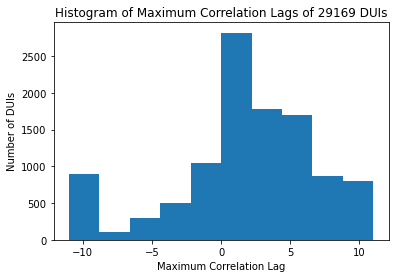

In [34]:
# create a histogram of the maximum correlation lags of duis in dui_subset, then plot it
dui_subset_mcclags = [dui2mcclag[dui] for dui in dui_subset if dui in dui2mcclag]
plt.hist(dui_subset_mcclags, bins=10)
plt.title('Histogram of Maximum Correlation Lags of ' + str(len(dui_subset)) + ' DUIs')
plt.xlabel('Maximum Correlation Lag')
plt.ylabel('Number of DUIs')
plt.show()

neg: 2857
zero: 1531
pos: 6434


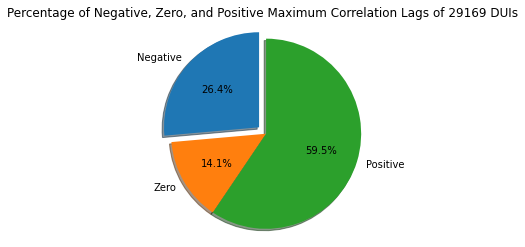

In [35]:
#return the percentage of negative, zero, and positive maximum correlation lags as a circle graph
dui_subset_mcclags = [dui2mcclag[dui] for dui in dui_subset if dui in dui2mcclag]
neg = len([lag for lag in dui_subset_mcclags if lag < 0])
zero = len([lag for lag in dui_subset_mcclags if lag == 0])
pos = len([lag for lag in dui_subset_mcclags if lag > 0])
print('neg:', neg)
print('zero:', zero)
print('pos:', pos)

labels = 'Negative', 'Zero', 'Positive'
sizes = [neg, zero, pos]
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
fig1.patch.set_facecolor('white')
plt.title('Percentage of Negative, Zero, and Positive Maximum Correlation Lags of ' + str(len(dui_subset)) + ' DUIs')
plt.show()

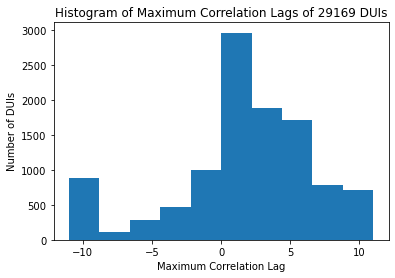

In [36]:
# create a histogram of the maximum correlation lags of duis in dui_subset, then plot it
dui_subset_mcclags = [dui2mcclagchild[dui] for dui in dui_subset if dui in dui2mcclagchild]
plt.hist(dui_subset_mcclags, bins=10)
plt.title('Histogram of Maximum Correlation Lags of ' + str(len(dui_subset)) + ' DUIs')
plt.xlabel('Maximum Correlation Lag')
plt.ylabel('Number of DUIs')
plt.show()

neg: 2747
zero: 1661
pos: 6414


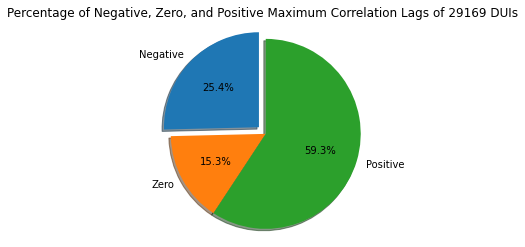

In [37]:
#return the percentage of negative, zero, and positive maximum correlation lags as a circle graph
dui_subset_mcclags = [dui2mcclagchild[dui] for dui in dui_subset if dui in dui2mcclagchild]
neg = len([lag for lag in dui_subset_mcclags if lag < 0])
zero = len([lag for lag in dui_subset_mcclags if lag == 0])
pos = len([lag for lag in dui_subset_mcclags if lag > 0])
print('neg:', neg)
print('zero:', zero)
print('pos:', pos)

labels = 'Negative', 'Zero', 'Positive'
sizes = [neg, zero, pos]
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
fig1.patch.set_facecolor('white')
plt.title('Percentage of Negative, Zero, and Positive Maximum Correlation Lags of ' + str(len(dui_subset)) + ' DUIs')
plt.show()

depth: 1
len(dui_subset_mcclags): 0
neg: 0 Ratio: 0.0
zero: 0 Ratio: 0.0
pos: 0 Ratio: 0.0
depth: 2
len(dui_subset_mcclags): 58
neg: 3 Ratio: 5.172413793014269
zero: 23 Ratio: 39.6551724131094
pos: 32 Ratio: 55.172413792152206


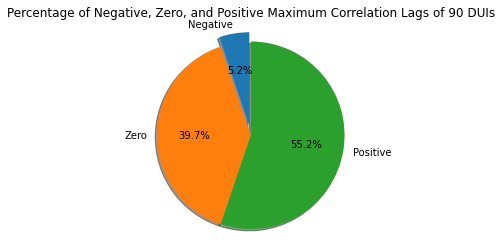

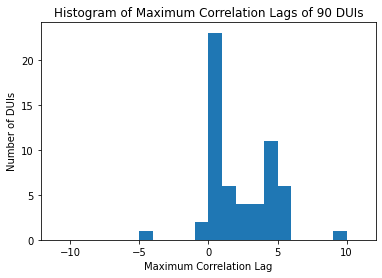

depth: 3
len(dui_subset_mcclags): 853
neg: 195 Ratio: 22.860492379809074
zero: 197 Ratio: 23.094958968319936
pos: 461 Ratio: 54.04454865175376


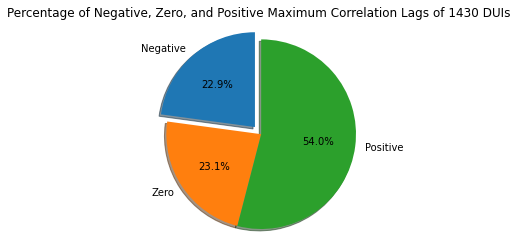

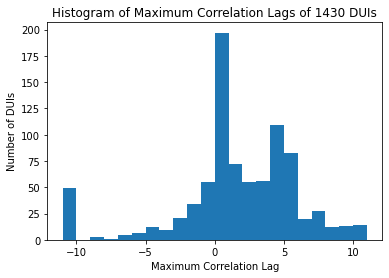

depth: 4
len(dui_subset_mcclags): 2976
neg: 724 Ratio: 24.327956989239137
zero: 579 Ratio: 19.455645161283787
pos: 1673 Ratio: 56.21639784944348


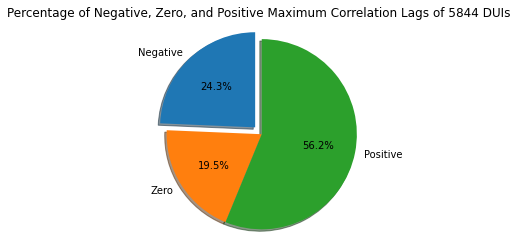

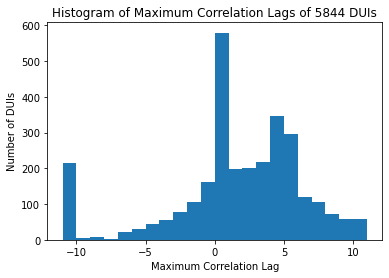

depth: 5
len(dui_subset_mcclags): 5653
neg: 1431 Ratio: 25.313992570312166
zero: 1006 Ratio: 17.795860604985354
pos: 3216 Ratio: 56.890146824684784


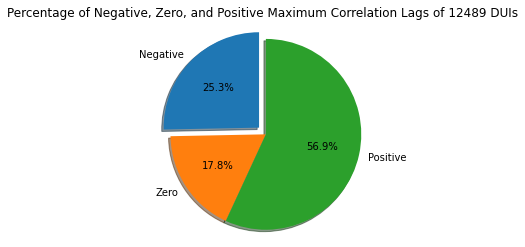

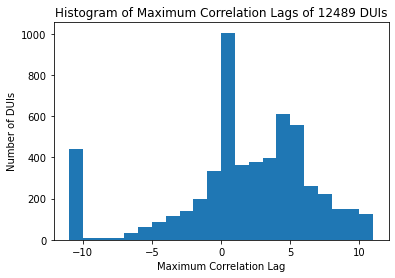

depth: 6
len(dui_subset_mcclags): 7880
neg: 2005 Ratio: 25.444162436544993
zero: 1311 Ratio: 16.63705583756134
pos: 4564 Ratio: 57.918781725880976


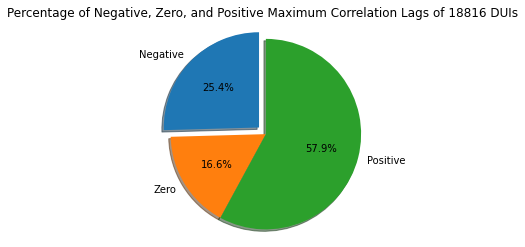

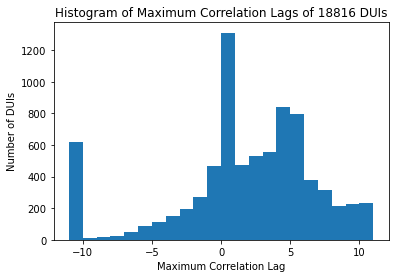

depth: 7
len(dui_subset_mcclags): 9283
neg: 2351 Ratio: 25.325864483461668
zero: 1489 Ratio: 16.040073252179678
pos: 5443 Ratio: 58.634062264347875


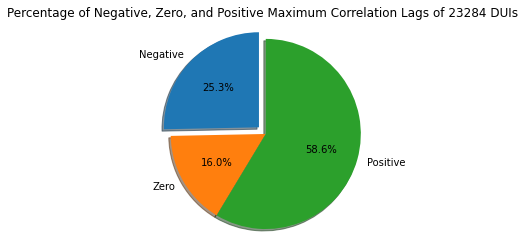

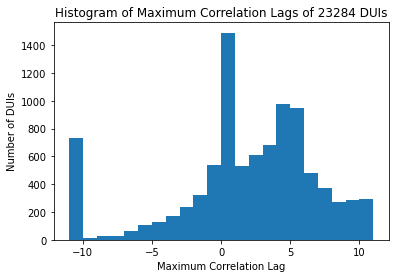

depth: 8
len(dui_subset_mcclags): 10019
neg: 2538 Ratio: 25.33186944804618
zero: 1565 Ratio: 15.620321389358654
pos: 5916 Ratio: 59.04780916258518


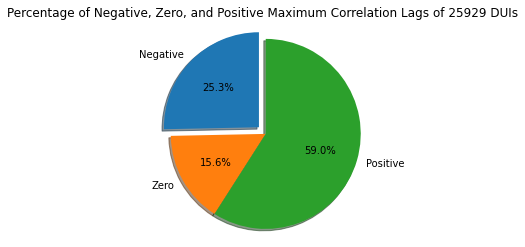

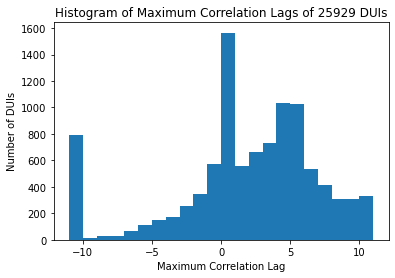

depth: 9
len(dui_subset_mcclags): 10491
neg: 2667 Ratio: 25.42179010580255
zero: 1612 Ratio: 15.365551425029514
pos: 6212 Ratio: 59.2126584691584


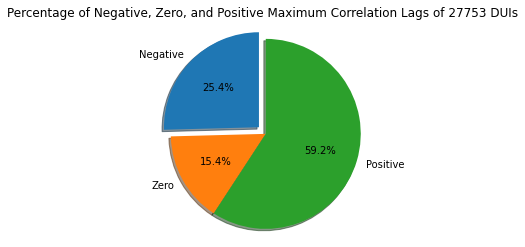

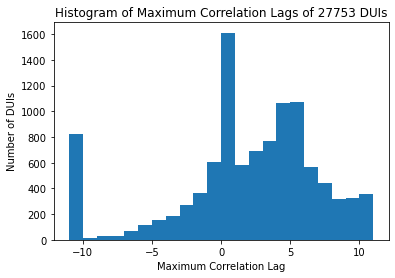

depth: 10
len(dui_subset_mcclags): 10714
neg: 2724 Ratio: 25.424677991410732
zero: 1642 Ratio: 15.325742019785762
pos: 6348 Ratio: 59.24957998879417


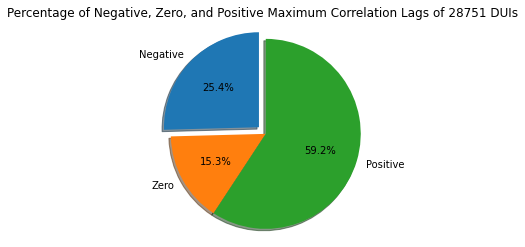

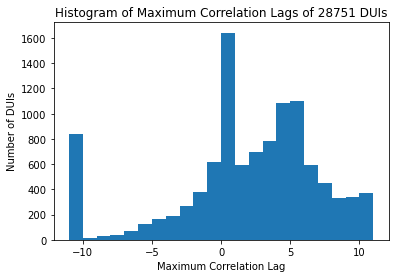

depth: 11
len(dui_subset_mcclags): 10822
neg: 2747 Ratio: 25.38347810016398
zero: 1661 Ratio: 15.34836444280028
pos: 6414 Ratio: 59.26815745702649


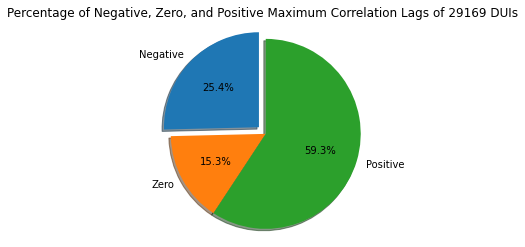

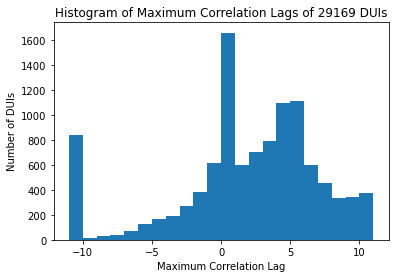

depth: 12
len(dui_subset_mcclags): 10853
neg: 2750 Ratio: 25.338616050859176
zero: 1666 Ratio: 15.350594305720506
pos: 6437 Ratio: 59.3107896434111


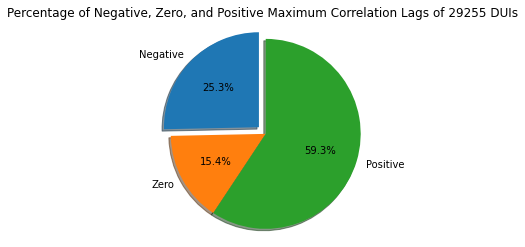

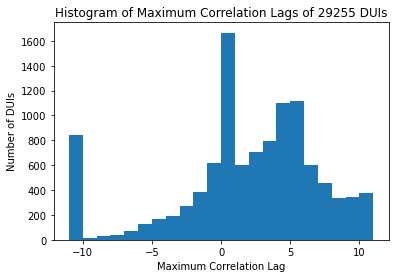

depth: 13
len(dui_subset_mcclags): 10864
neg: 2751 Ratio: 25.322164948451274
zero: 1667 Ratio: 15.3442562592033
pos: 6446 Ratio: 59.33357879233622


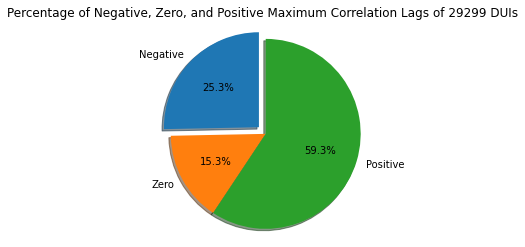

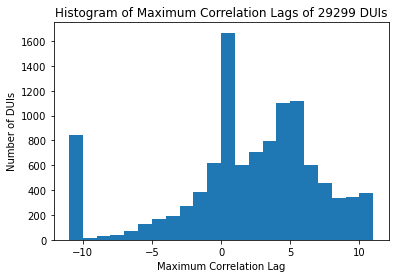

depth: 14
len(dui_subset_mcclags): 10873
neg: 2752 Ratio: 25.310401912993164
zero: 1667 Ratio: 15.331555228546367
pos: 6454 Ratio: 59.35804285845126


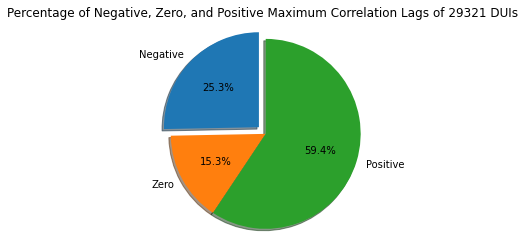

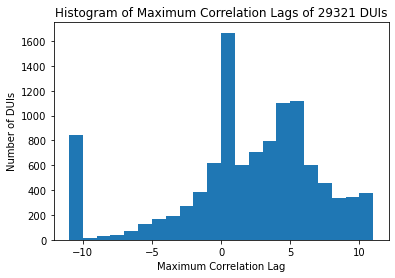

In [38]:
# iterate over max_depth and create a histogram of the maximum correlation lags of duis in dui_subset, then plot it
max_depth = 13
for depth in range(max_depth + 1):
    print('depth:', depth + 1)
    dui_subset = [dui for level in range(depth + 1) for dui in level2duis[level]]
    dui_subset_mcclags = [dui2mcclagchild[dui] for dui in dui_subset if dui in dui2mcclagchild]
    print('len(dui_subset_mcclags):', len(dui_subset_mcclags))
    neg = len([lag for lag in dui_subset_mcclags if lag < 0])
    zero = len([lag for lag in dui_subset_mcclags if lag == 0])
    pos = len([lag for lag in dui_subset_mcclags if lag > 0])
    # print the true value and percentage of negative, zero, and positive maximum correlation lags add 0.000000001 to avoid division by zero
    print('neg:', neg, 'Ratio:', neg / (len(dui_subset_mcclags) + 0.000000001) * 100)
    print('zero:', zero, 'Ratio:', zero / (len(dui_subset_mcclags) + 0.000000001) * 100)
    print('pos:', pos, 'Ratio:', pos / (len(dui_subset_mcclags) + 0.000000001) * 100)

    if neg + zero + pos == 0:
        print('=' * 50)
        continue

    # plot the three accuracy scores as a pie graph. choose the one pie graph that is empty in the middle   
    labels = 'Negative', 'Zero', 'Positive'
    sizes = [neg, zero, pos]
    explode = (0.1, 0, 0)
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    fig1.patch.set_facecolor('white')
    plt.title('Percentage of Negative, Zero, and Positive Maximum Correlation Lags of ' + str(len(dui_subset)) + ' DUIs')
    plt.show()

    # plot the histogram of the maximum correlation lags of dui_subset_mcclags. bound the x-axis to -11 to 11 with 1 intervals
    plt.hist(dui_subset_mcclags, bins=range(-11, 12, 1))
    plt.title('Histogram of Maximum Correlation Lags of ' + str(len(dui_subset)) + ' DUIs')
    plt.xlabel('Maximum Correlation Lag')
    plt.ylabel('Number of DUIs')
    plt.show()
    
    print('=' * 50)

depth: 1
len(dui_subset): 0
neg: 0 Ratio: 0.0
pos: 0 Ratio: 0.0
depth: 2
len(dui_subset): 58
neg: 14 Ratio: 24.13793103406659
pos: 44 Ratio: 75.86206896420929
len(dui_subset_single_level): 58


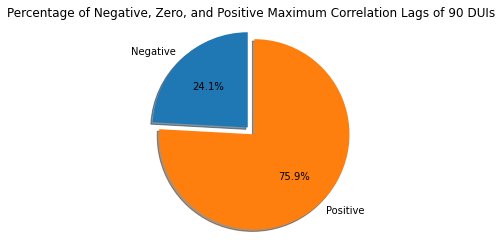

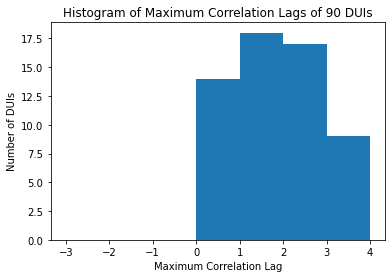

depth: 3
len(dui_subset): 853
neg: 220 Ratio: 25.791324736194852
pos: 633 Ratio: 74.20867526368792
len(dui_subset_single_level): 795


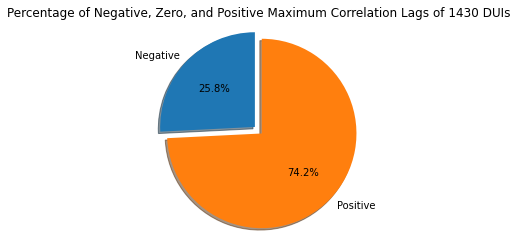

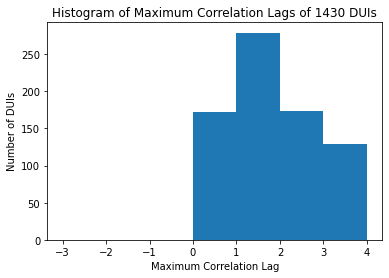

depth: 4
len(dui_subset): 2976
neg: 740 Ratio: 24.865591397841108
pos: 2236 Ratio: 75.13440860212529
len(dui_subset_single_level): 2123


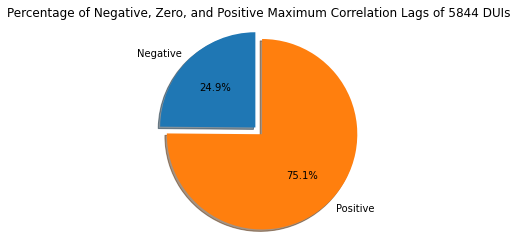

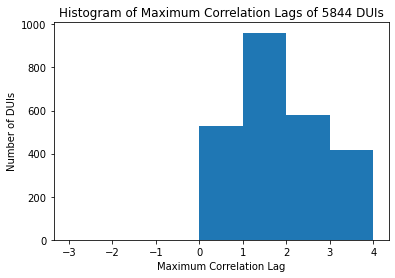

depth: 5
len(dui_subset): 5653
neg: 1435 Ratio: 25.3847514593976
pos: 4218 Ratio: 74.61524854058472
len(dui_subset_single_level): 2677


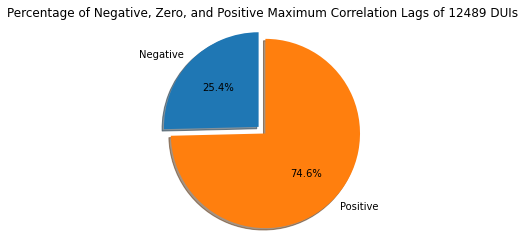

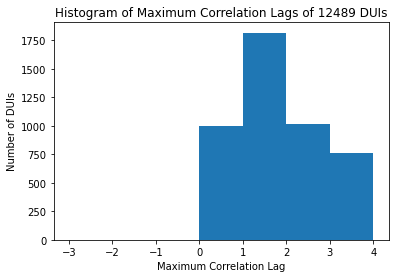

depth: 6
len(dui_subset): 7880
neg: 1970 Ratio: 24.999999999996824
pos: 5910 Ratio: 74.99999999999048
len(dui_subset_single_level): 2227


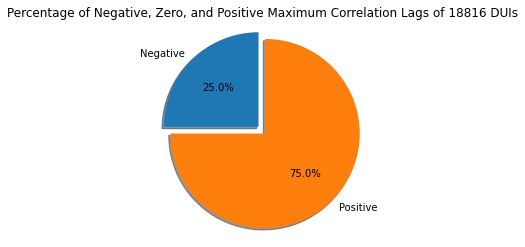

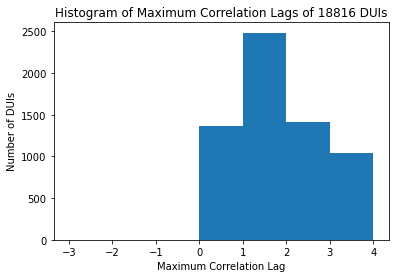

depth: 7
len(dui_subset): 9283
neg: 2310 Ratio: 24.884196919096745
pos: 6973 Ratio: 75.11580308089248
len(dui_subset_single_level): 1403


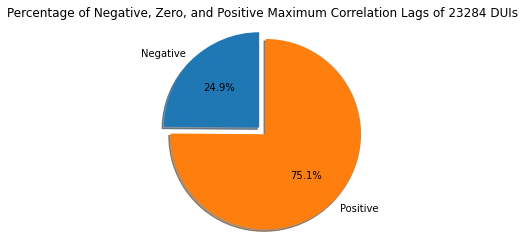

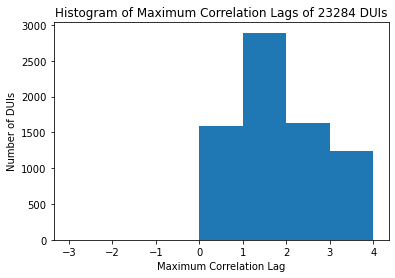

depth: 8
len(dui_subset): 10019
neg: 2479 Ratio: 24.742988322185372
pos: 7540 Ratio: 75.25701167780464
len(dui_subset_single_level): 736


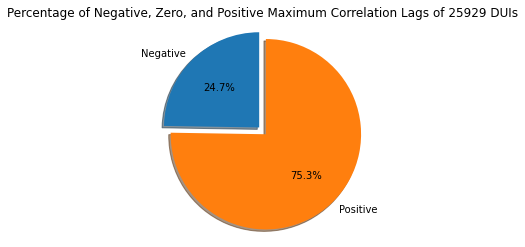

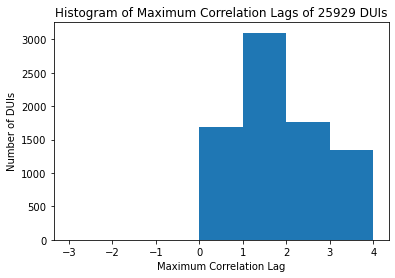

depth: 9
len(dui_subset): 10491
neg: 2584 Ratio: 24.630635783049794
pos: 7907 Ratio: 75.36936421694067
len(dui_subset_single_level): 472


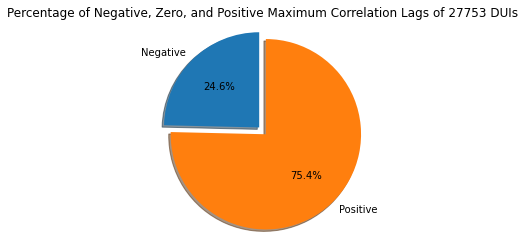

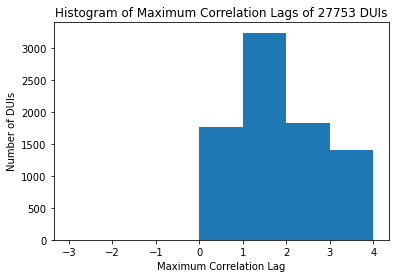

depth: 10
len(dui_subset): 10714
neg: 2634 Ratio: 24.58465559081346
pos: 8080 Ratio: 75.4153444091772
len(dui_subset_single_level): 223


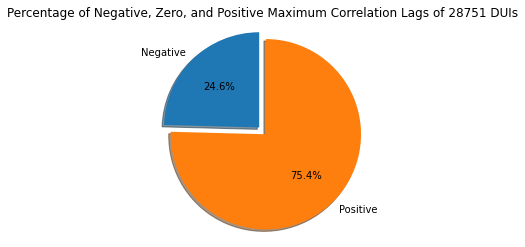

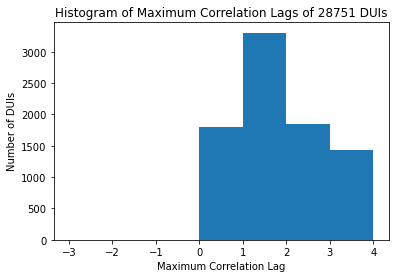

depth: 11
len(dui_subset): 10822
neg: 2663 Ratio: 24.607281463682813
pos: 8159 Ratio: 75.39271853630794
len(dui_subset_single_level): 108


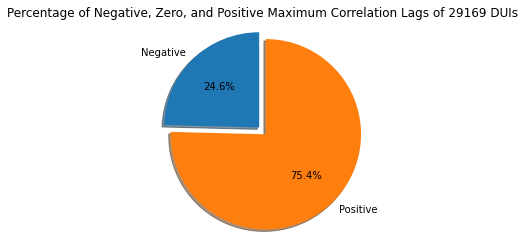

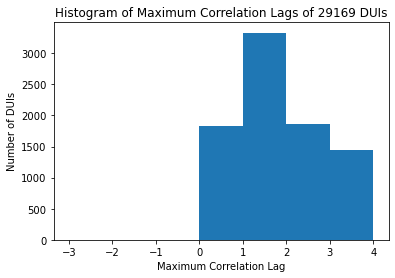

depth: 12
len(dui_subset): 10853
neg: 2668 Ratio: 24.58306459043356
pos: 8185 Ratio: 75.41693540955723
len(dui_subset_single_level): 31


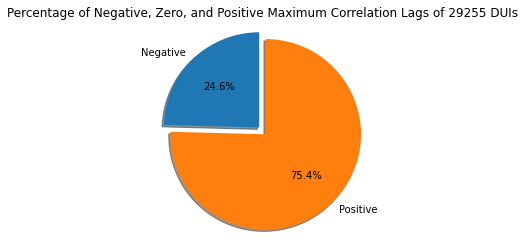

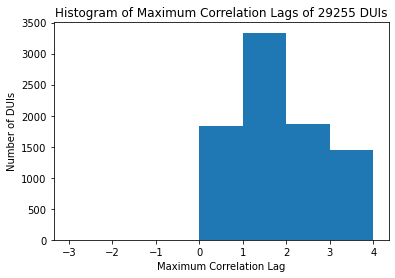

depth: 13
len(dui_subset): 10864
neg: 2669 Ratio: 24.567378497788606
pos: 8195 Ratio: 75.43262150220218
len(dui_subset_single_level): 11


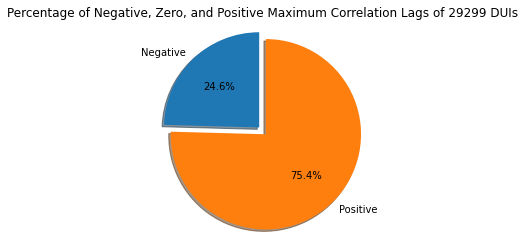

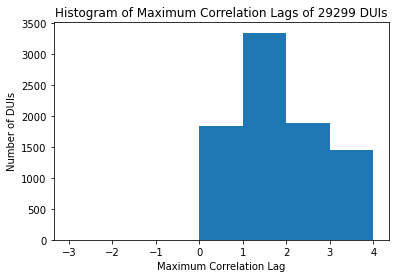

depth: 14
len(dui_subset): 10873
neg: 2670 Ratio: 24.556240228085667
pos: 8203 Ratio: 75.44375977190514
len(dui_subset_single_level): 9


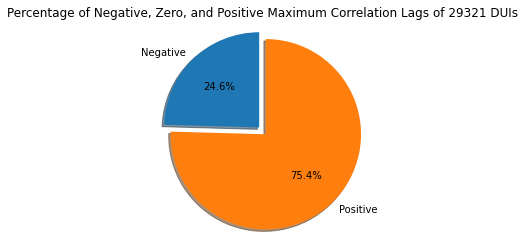

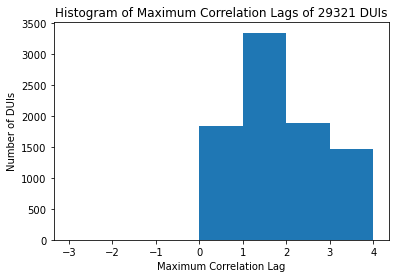

In [41]:
# iterate over max_depth and create a histogram of the maximum correlation lags of duis in dui_subset, then plot it
max_depth = 13
single_level_duis_mcclags = []
single_level_duis = []
multi_level_duis_mcclags = []
greater_one_percentages = []
greater_one_std = []
greater_one_maxs = []
greater_one_mins = []
for depth in range(max_depth + 1):
    print('depth:', depth + 1)
    dui_subset = [dui for level in range(depth + 1) for dui in level2duis[level]]
    dui_subset_mcclags = [dui2aucratiochild[dui] for dui in dui_subset if dui in dui2aucratiochild]
    print('len(dui_subset):', len(dui_subset_mcclags))
    neg = len([lag for lag in dui_subset_mcclags if lag <= 1])
    pos = len([lag for lag in dui_subset_mcclags if lag > 1])
    ppos = pos / (len(dui_subset_mcclags) + 0.000000001) * 100
    # pzero = zero / (len(dui_subset_mcclags) + 0.000000001) * 100
    pneg = neg / (len(dui_subset_mcclags) + 0.000000001) * 100
    # print the true value and percentage of negative, zero, and positive maximum correlation lags add 0.000000001 to avoid division by zero
    print('neg:', neg, 'Ratio:', pneg)
    # print('zero:', zero, 'Ratio:', pzero)
    print('pos:', pos, 'Ratio:', ppos)

    if neg + pos == 0:
        print('=' * 50)
        continue

    dui_subset_single_level = [dui for dui in level2duis[depth] if dui in dui2aucratiochild]
    single_level_duis.append(dui_subset_single_level)
    print('len(dui_subset_single_level):', len(dui_subset_single_level))
    dui_subset_single_level_mcclags = [dui2aucratiochild[dui] for dui in dui_subset_single_level]
    single_level_duis_mcclags.append(dui_subset_single_level_mcclags)
    greater_one_maxs.append([dui_subset_single_level[np.argmax(dui_subset_single_level_mcclags)], np.max(dui_subset_single_level_mcclags)])
    greater_one_mins.append([dui_subset_single_level[np.argmin(dui_subset_single_level_mcclags)], np.min(dui_subset_single_level_mcclags)])
    dui_greater_one_std = np.std(dui_subset_single_level_mcclags)
    greater_one_std.append(dui_greater_one_std)
    greater_one_percentages.append(ppos)
    multi_level_duis_mcclags.append(dui_subset_mcclags)
    
    # plot the three accuracy scores as a pie graph. choose the one pie graph that is empty in the middle   
    labels = 'Negative', 'Positive'
    sizes = [neg, pos]
    explode = (0.1, 0)
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    fig1.patch.set_facecolor('white')
    plt.title('Percentage of Negative, Zero, and Positive Maximum Correlation Lags of ' + str(len(dui_subset)) + ' DUIs')
    plt.show()

    # plot the histogram of the maximum correlation lags of dui_subset_mcclags. bound the x-axis to -3 to 5 with 1 intervals
    plt.hist(dui_subset_mcclags, bins=range(-3, 5, 1))
    plt.title('Histogram of Maximum Correlation Lags of ' + str(len(dui_subset)) + ' DUIs')
    plt.xlabel('Maximum Correlation Lag')
    plt.ylabel('Number of DUIs')
    plt.show()

   #save pos / (len(dui_subset_mcclags) + 0.000000001) * 100 to a txt file named like STIDX_<START_FROM_IDX>_DEPTH_<depth>.txt at data/SF11/results
    with open(LAG_DATA_ADDRESS + SF_TAG + '/results/DEPTH_' + str(depth) + '_IMP.txt', 'w') as f:
        f.write(str(ppos))
    
    print('=' * 50)

In [45]:
import os

SFS = ['SF10', 'SF11', 'SF12', 'SF13', 'SF14', 'SF15', 'SF16', 'SF17', 'SF18', 'SF19', 'SF20']
max_window_freq_percents, max_window_imp_percents = [], []
freq_std, imp_std = [], []

for depth in range(1, 14):
    freq_percents_across_years, imp_percents_across_years = [], []
    for sf in SFS:
        freq_address = LAG_DATA_ADDRESS + sf + '/results/DEPTH_' + str(depth) + '_FREQ.txt'
        imp_address = LAG_DATA_ADDRESS + sf + '/results/DEPTH_' + str(depth) + '_IMP.txt'
        with open(freq_address, 'r') as f:
            freq = float(f.read())
        with open(imp_address, 'r') as f:
            imp = float(f.read())
        freq_percents_across_years.append(freq)
        imp_percents_across_years.append(imp)
        if sf == 'SF10':
            max_window_freq_percents.append(freq)
            max_window_imp_percents.append(imp)
    
    freq_std.append(np.std(freq_percents_across_years))
    imp_std.append(np.std(imp_percents_across_years))
    print('depth:', depth)
    print('freq_percents_across_years:', freq_percents_across_years)
    print('imp_percents_across_years:', imp_percents_across_years)
    print('freq_percents_across_years std:', np.std(freq_percents_across_years))
    print('imp_percents_across_years std:', np.std(imp_percents_across_years))

len(freq_std), len(imp_std), len(max_window_freq_percents), len(max_window_imp_percents)

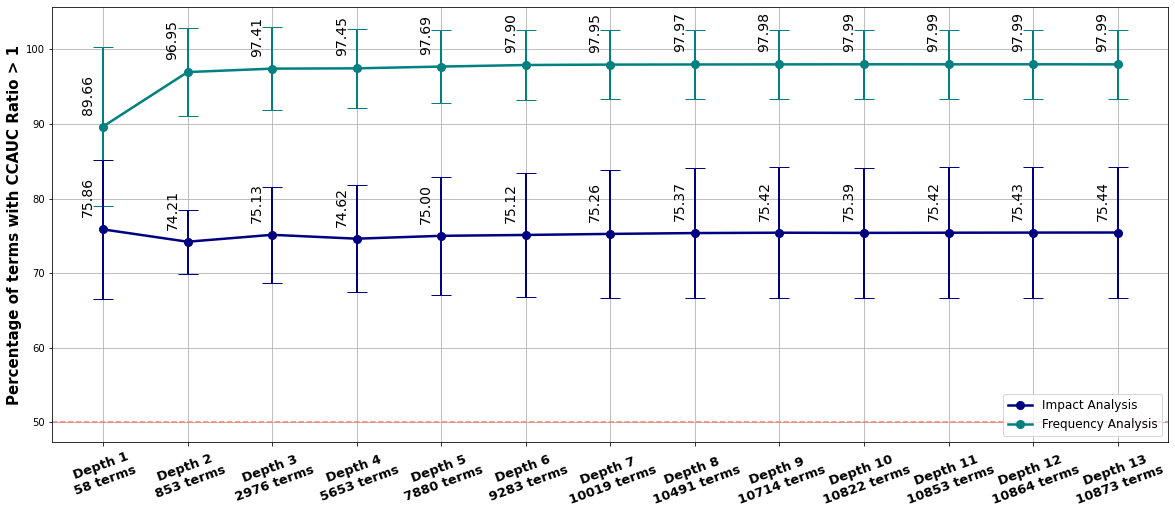

In [44]:
import matplotlib.pyplot as plt

x = ['Depth ' + str(each + 1) + '\n' + str(len(multi_level_duis_mcclags[each])) + ' terms' for each in range(len(greater_one_percentages))]

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)
ax.axhline(y=50, color='salmon', linestyle='--')
ax.errorbar(x, max_window_freq_percents, yerr=freq_std, fmt='o', ecolor='teal', elinewidth=2, capsize=10, color='teal')
ax.errorbar(x, max_window_imp_percents, yerr=imp_std, fmt='o', ecolor='navy', elinewidth=2, capsize=10, color='navy')
line1, = ax.plot(x, max_window_imp_percents, marker='o', color='navy', linewidth=2.5, markersize=8, label='Impact Analysis')
line2, = ax.plot(x, max_window_freq_percents, marker='o', color='teal', linewidth=2.5, markersize=8, label='Frequency Analysis')

ax.grid(True)  # Add gridlines
ax.set_ylabel('Percentage of terms with CCAUC Ratio > 1', fontsize=15, weight='bold')
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x, rotation=20, fontsize=13, weight='bold')
ax.set_yticks(range(50, 101, 10))  # Set y-axis ticks from 50 to 100 in steps of 10

# Add annotations for the first line
for i, val in enumerate(max_window_imp_percents):
    val_formatted = '{:.2f}'.format(val)
    ax.annotate(f'{val_formatted}', (i, val), textcoords="offset points", xytext=(-15, 15), ha='center', fontsize=14, color='black', rotation=90)

# Add annotations for the second line
for i, val in enumerate(max_window_freq_percents):
    val_formatted = '{:.2f}'.format(val)
    ax.annotate(f'{val_formatted}', (i, val), textcoords="offset points", xytext=(-15, 15), ha='center', fontsize=14, color='black', rotation=90)

ax.legend(loc='lower right', fontsize='large')  # Move the legend to the bottom right
plt.savefig('impact_vs_freq.png', dpi=300, bbox_inches='tight')
plt.show()